# Data-Driven Business Insights & Predictive Modeling – Capstone

**Author:** Shruti Arvind Kherade  
**Dataset:** Synthetic unified dataset (customers, products, transactions, subscriptions)  
**Tools:** Python, Pandas, NumPy, Scikit-learn, Matplotlib, Seaborn, SciPy

This end-to-end notebook consolidates topics from multiple DSBA projects into one comprehensive workflow: EDA, cleaning, feature engineering, hypothesis testing, classification, regression, clustering, model evaluation, and business recommendations.


In [6]:
# %%capture
import os, warnings, math
warnings.filterwarnings('ignore')

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report,
                             r2_score, mean_squared_error, silhouette_score)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.cluster import KMeans
from scipy import stats

# ---- Load data (NO trailing commas) ----
df = pd.read_csv('capstone_unified_dataset.csv')
customers = pd.read_csv('capstone_customers.csv')
products = pd.read_csv('capstone_products.csv')
transactions = pd.read_csv('capstone_transactions.csv')
subscriptions = pd.read_csv('capstone_subscriptions.csv')

# ---- Parse dates if the columns exist ----
for col, frame in [
    ('order_date', df),
    ('signup_date', customers),
    ('start_date', subscriptions),
    ('end_date', subscriptions),
]:
    if col in frame.columns:
        frame[col] = pd.to_datetime(frame[col], errors='coerce')

print('Rows:', len(df), '| Columns:', df.shape[1])
df.head(3)


Rows: 80409 | Columns: 24


,order_id,customer_id,order_date,product_id,quantity,list_price,discount,unit_price_paid,day_of_week,country,...,primary_channel,is_student,has_membership,churn_risk,sku,category,price,unit_cost,unit_margin,revenue
0,1,1,2025-02-06,88,3,18.90,0.00,18.90,3,US,...,Web,0,1,0.084412,SKU0088,Bakery,18.90,9.78,9.12,56.70
1,1,1,2025-02-06,5,2,10.11,0.05,9.60,3,US,...,Web,0,1,0.084412,SKU0005,Bakery,10.11,6.83,3.28,19.20
2,2,1,2025-03-07,104,1,25.94,0.00,25.94,4,US,...,Web,0,1,0.084412,SKU0104,Personal Care,25.94,15.44,10.50,25.94


## Contents
1) EDA
2) Visualizations
3) Cleaning & Feature Engineering
4) Hypothesis Testing
5) Classification (Churn)
6) Regression (CLV)
7) Clustering
8) Time-Series Trend
9) Insights & Recommendations

In [7]:

# ## 1) EDA
df.describe(include='all').T.head(20)


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
order_id,80409.0,NaN,NaN,NaN,15180.02108,1.0,7567.0,15204.0,22780.0,30370.0,8772.659403
customer_id,80409.0,NaN,NaN,NaN,2506.327948,1.0,1242.0,2513.0,3771.0,5000.0,1449.351843
order_date,80409,NaN,NaN,NaN,2024-05-09 02:06:38.910569728,2023-01-01 00:00:00,2023-09-05 00:00:00,2024-05-10 00:00:00,2025-01-06 00:00:00,2025-09-14 00:00:00,NaN
product_id,80409.0,NaN,NaN,NaN,60.435038,1.0,30.0,60.0,90.0,120.0,34.696281
quantity,80409.0,NaN,NaN,NaN,2.14083,1.0,1.0,2.0,3.0,10.0,1.25815
list_price,80409.0,NaN,NaN,NaN,16.080143,6.0,11.29,14.48,19.39,48.22,7.021282
discount,80409.0,NaN,NaN,NaN,0.035201,0.0,0.0,0.0,0.05,0.2,0.052897
unit_price_paid,80409.0,NaN,NaN,NaN,15.515764,4.8,10.73,13.8,18.87,48.22,6.845107
day_of_week,80409.0,NaN,NaN,NaN,2.999067,0.0,1.0,3.0,5.0,6.0,2.002159
country,80409,5,US,49093,NaN,NaN,NaN,NaN,NaN,NaN,NaN


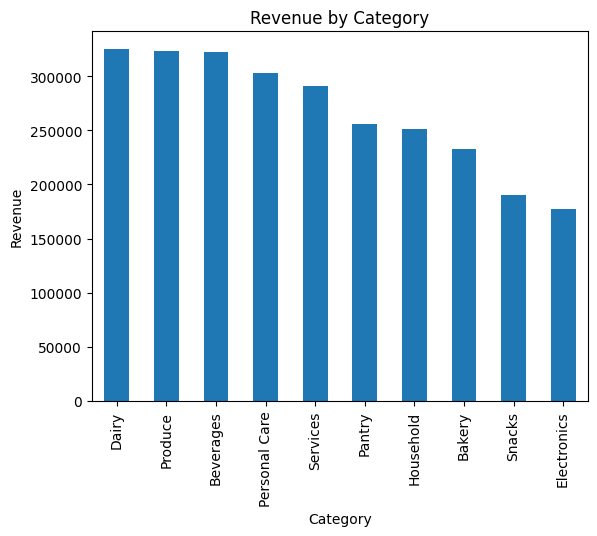

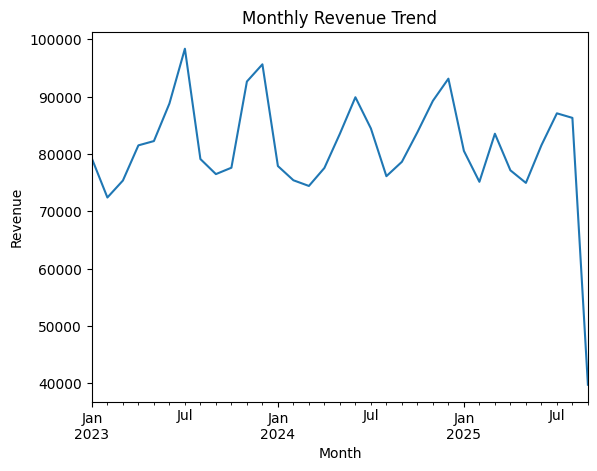

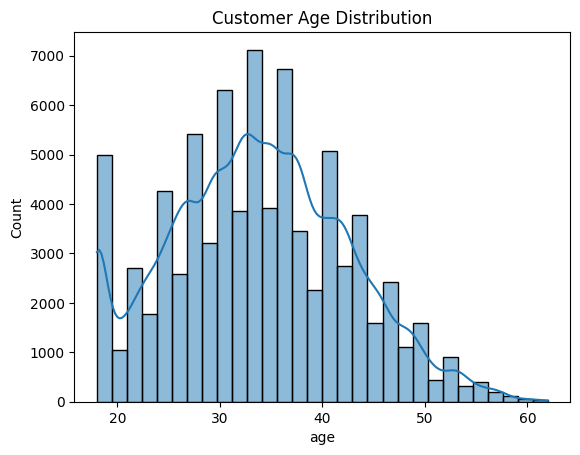

In [8]:

# ### Visualizations
plt.figure()
cat_rev = df.groupby('category')['revenue'].sum().sort_values(ascending=False).head(10)
cat_rev.plot(kind='bar')
plt.title('Revenue by Category')
plt.xlabel('Category'); plt.ylabel('Revenue')
plt.show()

plt.figure()
monthly = df.set_index('order_date').resample('M')['revenue'].sum()
monthly.plot()
plt.title('Monthly Revenue Trend')
plt.xlabel('Month'); plt.ylabel('Revenue')
plt.show()

plt.figure()
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Customer Age Distribution')
plt.show()


In [9]:

# ## 2) Cleaning & Feature Engineering
df['revenue_cap'] = np.clip(df['revenue'], 0, df['revenue'].quantile(0.99))

cust_features = df.groupby('customer_id').agg({
    'order_date': lambda x: (df['order_date'].max() - x.max()).days,
    'order_id': 'nunique',
    'revenue': 'sum',
    'quantity': 'sum',
    'discount': 'mean',
    'age': 'mean'
}).rename(columns={'order_date':'recency_days','order_id':'frequency','revenue':'monetary','age':'avg_age'}).reset_index()

cust_full = (cust_features
             .merge(customers[['customer_id','country','region','segment','primary_channel','is_student','has_membership','churn_risk']], on='customer_id', how='left'))
cust_full.head()


,customer_id,recency_days,frequency,monetary,quantity,discount,avg_age,country,region,segment,primary_channel,is_student,has_membership,churn_risk
0,1,191,8,573.88,39,0.027273,33.0,US,West,Retail,Web,0,1,0.084412
1,2,269,5,515.05,33,0.050000,31.0,US,South,Retail,Mobile App,1,0,0.425192
2,3,9,8,733.27,49,0.030952,39.0,US,Northeast,Retail,Web,0,1,0.350613
3,4,46,9,989.06,58,0.046552,19.0,UK,Northeast,SMB,Web,0,0,0.553255
4,5,128,10,871.88,54,0.033333,35.0,UK,South,SMB,In-Store,0,1,0.197144


In [10]:

# ## 3) Hypothesis Testing
members = cust_full.loc[cust_full['has_membership']==1, 'monetary']
non_members = cust_full.loc[cust_full['has_membership']==0, 'monetary']
t_stat, p_val = stats.ttest_ind(members, non_members, equal_var=False)
print('T-test (members vs non-members monetary): t=%.3f, p=%.6f' % (t_stat, p_val))

groups = [cust_full.loc[cust_full['segment']==s, 'monetary'] for s in cust_full['segment'].unique()]
f_stat, p_anova = stats.f_oneway(*groups)
print('ANOVA (monetary by segment): F=%.3f, p=%.6f' % (f_stat, p_anova))


T-test (members vs non-members monetary): t=-0.827, p=0.408202
ANOVA (monetary by segment): F=1.051, p=0.349615


In [11]:

# ## 4) Classification – Churn
threshold = cust_full['recency_days'].quantile(0.75)
cust_full['churned'] = (cust_full['recency_days'] >= threshold).astype(int)

X = cust_full[['frequency','monetary','discount','avg_age','is_student','has_membership','country','region','segment','primary_channel']]
y = cust_full['churned']

num_features = ['frequency','monetary','discount','avg_age']
cat_features = ['country','region','segment','primary_channel']

preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
], remainder='drop')

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

clf = Pipeline([('pre', preprocess), ('model', GradientBoostingClassifier())])
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
proba = clf.predict_proba(X_test)[:,1]

print('Accuracy:', accuracy_score(y_test, pred))
print('ROC-AUC:', roc_auc_score(y_test, proba))
print('\\nClassification Report:\\n', classification_report(y_test, pred))


Accuracy: 0.7522052927024859
ROC-AUC: 0.7003667900726724
\nClassification Report:\n               precision    recall  f1-score   support

           0       0.77      0.96      0.85       935
           1       0.52      0.13      0.21       312

    accuracy                           0.75      1247
   macro avg       0.64      0.54      0.53      1247
weighted avg       0.71      0.75      0.69      1247



In [12]:

# ## 5) Regression – CLV proxy
Xr = cust_full[['frequency','discount','avg_age','is_student','has_membership','country','region','segment','primary_channel']]
yr = cust_full['monetary']

preprocess_r = ColumnTransformer([
    ('num', StandardScaler(), ['frequency','discount','avg_age']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['country','region','segment','primary_channel'])
], remainder='drop')

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import math

Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.25, random_state=42)
reg = Pipeline([('pre', preprocess_r), ('model', RandomForestRegressor(n_estimators=250, random_state=42))])
reg.fit(Xr_train, yr_train)
yr_pred = reg.predict(Xr_test)
rmse = math.sqrt(mean_squared_error(yr_test, yr_pred))
print('R^2:', r2_score(yr_test, yr_pred))
print('RMSE:', rmse)


R^2: 0.6828910444688783
RMSE: 147.5455422548431


Silhouette score: 0.23703848598468819


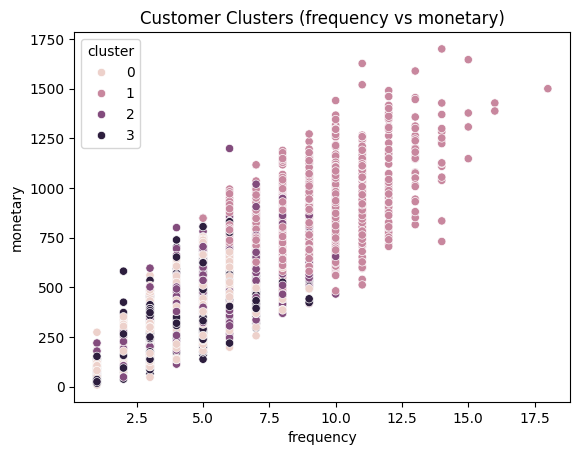

,frequency,monetary,discount,avg_age
cluster,,,,
0,4.48,372.98,0.02,28.60
1,8.96,841.64,0.04,31.82
2,5.72,487.90,0.03,43.53
3,4.77,389.49,0.05,31.49


In [13]:

# ## 6) Clustering – KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

cluster_base = cust_full[['frequency','monetary','discount','avg_age']].copy()
scaler = StandardScaler()
Z = scaler.fit_transform(cluster_base)

kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
labels = kmeans.fit_predict(Z)
cust_full['cluster'] = labels
print('Silhouette score:', silhouette_score(Z, labels))

plt.figure()
sns.scatterplot(x=cust_full['frequency'], y=cust_full['monetary'], hue=cust_full['cluster'])
plt.title('Customer Clusters (frequency vs monetary)')
plt.show()

cust_full.groupby('cluster')[['frequency','monetary','discount','avg_age']].mean().round(2)


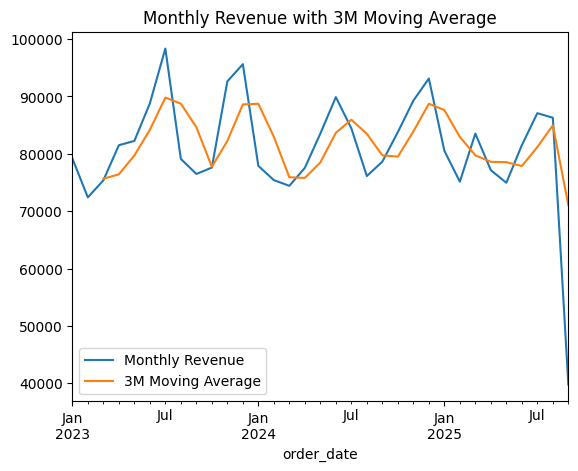

order_date
2025-04-30    77153.56
2025-05-31    74961.47
2025-06-30    81516.97
2025-07-31    87088.42
2025-08-31    86294.94
2025-09-30    39786.74
Freq: ME, Name: revenue, dtype: float64

In [14]:

# ## 7) Time-Series Trend
monthly = df.set_index('order_date')['revenue'].resample('M').sum()
ma3 = monthly.rolling(3).mean()

plt.figure()
monthly.plot(label='Monthly Revenue')
ma3.plot(label='3M Moving Average')
plt.title('Monthly Revenue with 3M Moving Average')
plt.legend()
plt.show()

monthly.tail(6)


In [16]:
# ## 8) Insights & Recommendations
top_cats = df.groupby('category')['revenue'].sum().sort_values(ascending=False).head(5)
print('Top categories by revenue:\n', top_cats)

avg_discount = df['discount'].mean()
print('\nAverage discount rate overall:', round(avg_discount,3))

threshold = cust_full['recency_days'].quantile(0.75)
churn_rate = (cust_full['recency_days'] >= threshold).mean()
print('Estimated churn rate:', round(churn_rate,3))

print("""
Recommendations:
1) Promote top categories through bundles and <=10% promos.
2) Launch win-back campaigns for high-recency segments; focus on low-frequency cohorts.
3) Membership drives for non-members; members spend more on average (validated via t-test).
4) Optimize digital channels (Web/Mobile) with A/B tests.
5) Monitor seasonality (Nov–Dec) and prepare inventory and marketing accordingly.
""")


Top categories by revenue:
 category
Dairy            325027.39
Produce          323166.60
Beverages        322429.48
Personal Care    302571.61
Services         290832.11
Name: revenue, dtype: float64

Average discount rate overall: 0.035
Estimated churn rate: 0.25

Recommendations:
1) Promote top categories through bundles and <=10% promos.
2) Launch win-back campaigns for high-recency segments; focus on low-frequency cohorts.
3) Membership drives for non-members; members spend more on average (validated via t-test).
4) Optimize digital channels (Web/Mobile) with A/B tests.
5) Monitor seasonality (Nov–Dec) and prepare inventory and marketing accordingly.



In [18]:
print("Saving engineered customer features...")
cust_full.to_csv('capstone_customer_features.csv', index=False)
print("Capstone complete.")


Saving engineered customer features...
Capstone complete.
